/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 01
	Train Loss: 0.642 | Train Acc: 63.50%
	 Val. Loss: 0.487 |  Val. Acc: 78.32%
Epoch: 02
	Train Loss: 0.504 | Train Acc: 75.46%
	 Val. Loss: 0.414 |  Val. Acc: 81.43%

Sentiment Analysis Tool
Type 'quit' to exit
----------------------


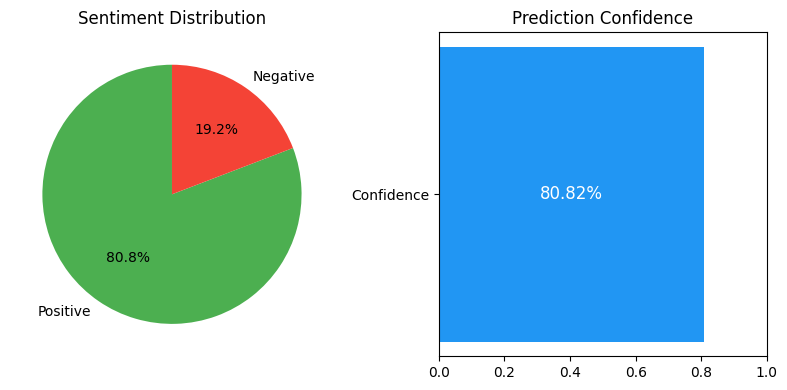


Sentiment: Positive | Confidence: 0.8082


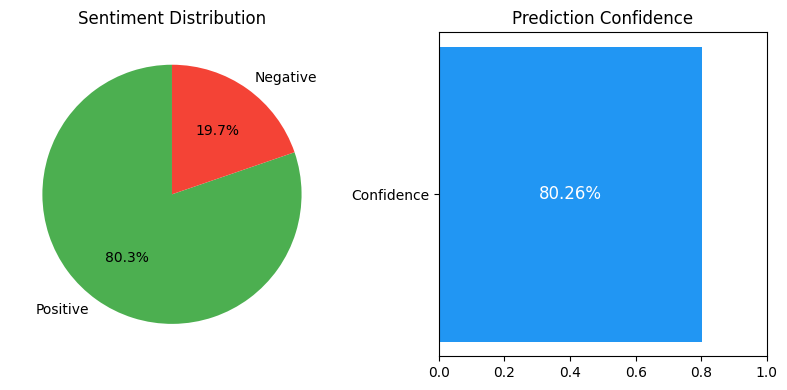


Sentiment: Positive | Confidence: 0.8026


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import random
import string
from transformers import BertTokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt 

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load IMDb dataset
imdb = load_dataset('imdb')
train_test_split = imdb['train'].train_test_split(test_size=0.2, seed=SEED)
train_data, valid_data = train_test_split['train'], train_test_split['test']
test_data = imdb['test']

# Vocabulary and tokenization
MAX_VOCAB_SIZE = 25_000
PAD_IDX, UNK_IDX = 0, 1

def tokenize(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text.split()

def build_vocab(dataset, max_size):
    counter = Counter()
    for example in dataset:
        tokens = tokenize(example['text'])
        counter.update(tokens)
    vocab = ['<pad>', '<unk>'] + [word for word, _ in counter.most_common(max_size-2)]
    return {word: idx for idx, word in enumerate(vocab)}

word2idx = build_vocab(train_data, MAX_VOCAB_SIZE)

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, data, word2idx, max_length=256):
        self.data = data
        self.word2idx = word2idx
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = 1.0 if self.data[idx]['label'] == 1 else 0.0
        
        tokens = tokenize(text)[:self.max_length]
        indices = [self.word2idx.get(token, UNK_IDX) for token in tokens]
        
        # Pad sequences
        if len(indices) < self.max_length:
            indices += [PAD_IDX] * (self.max_length - len(indices))
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# CNN Model (best performing from your notebooks)
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Model parameters
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = word2idx['<pad>']

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

# Training setup
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Create dataloaders
BATCH_SIZE = 64
train_dataset = IMDBDataset(train_data, word2idx)
valid_dataset = IMDBDataset(valid_data, word2idx)
test_dataset = IMDBDataset(test_data, word2idx)

def collate_batch(batch):
    texts, labels = zip(*batch)
    return torch.stack(texts), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

# Training functions
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Train the model (you can skip this if you have a saved model)
N_EPOCHS = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'sentiment-model.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Load the best model
model.load_state_dict(torch.load('sentiment-model.pt'))

# Prediction function
def predict_sentiment(model, sentence, word2idx, device, max_length=256):
    model.eval()
    tokens = tokenize(sentence)[:max_length]
    indices = [word2idx.get(token, UNK_IDX) for token in tokens]
    
    if len(indices) < max_length:
        indices += [PAD_IDX] * (max_length - len(indices))
        
    tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor))
    return "Positive" if prediction.item() > 0.5 else "Negative", prediction.item()

# Interactive loop
if __name__ == "__main__":
    print("\nSentiment Analysis Tool")
    print("Type 'quit' to exit")
    print("----------------------")
    
    while True:
        text = input("\nEnter a statement to analyze: ")
        if text.lower() == 'quit':
            break
            
        sentiment, confidence = predict_sentiment(model, text, word2idx, device)
        
        # Create visualization
        plt.figure(figsize=(8, 4))
        
        # Pie chart
        plt.subplot(1, 2, 1)
        labels = ['Positive', 'Negative']
        sizes = [confidence, 1 - confidence]
        colors = ['#4CAF50', '#F44336']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Sentiment Distribution')
        
        # Confidence bar
        plt.subplot(1, 2, 2)
        plt.barh(['Confidence'], [confidence], color='#2196F3')
        plt.xlim(0, 1)
        plt.title('Prediction Confidence')
        plt.text(confidence/2, 0, f"{confidence:.2%}", 
                ha='center', va='center', color='white', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSentiment: {sentiment} | Confidence: {confidence:.4f}")